# Unraveling Wine Quality Patterns - Model Definition / Training / Tunning
    IBM Data Science Capstone Project

## REPORT

The first goal of this project is to find the best **Machine Learning** model to both predict the wine quialty based on its chemical properties and to undertand the patterns with a second model that can easily classify the wine into red or white based on the same chemical properties (the color will also be used as a feature for the quality prediction model as one chemical property could be good for a red wine and bad for a white wine).

The procedure will be as follows:
1. Find the best features for each model
2. Find the best hyperparameters for each model
3. Train the best combination
4. Evaluate it
5. Compare with the other models and select the best one
6. Interpret the results

The second goal will be to train two **Deep Learning** models to compare with the best **Machine Learning** models and to see if the patterns are better understood using DL.

## Environment Set Up

### Requisites

In [1]:
!pip install pandas matplotlib scikit-learn tqdm torch

### Imports

In [2]:
import torch
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier

### Config

In [3]:
%matplotlib inline
pd.set_option('display.max_columns', None)
torch.manual_seed(33)

## Load Data

In [4]:
wines = pd.read_csv('./data/wine_quality_preprocessed.csv')
wines

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white,color
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,5,1,0,red
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068,5,1,0,red
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068,5,1,0,red
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068,6,1,0,red
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464,5,1,0,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.783214,-0.787650,-0.197054,-0.807837,-0.486252,-0.367664,-0.420128,-1.186161,0.320319,-0.210144,0.593818,6,0,1,white
6493,-0.474652,-0.119460,0.284686,0.537425,-0.257883,1.491697,0.924588,0.067824,-0.426067,-0.478971,-0.747766,5,0,1,white
6494,-0.551792,-0.605417,-0.885253,-0.891916,-0.429160,-0.029599,-0.083949,-0.719251,-1.421248,-0.478971,-0.915464,6,0,1,white
6495,-1.323198,-0.301694,-0.128234,-0.912936,-0.971538,-0.593041,-0.101642,-2.003251,0.755710,-1.016626,1.935402,7,0,1,white


## Model Tunning and Training Function for ML Models

This function will find the best model hyperparameters combination and train said model given:
- Model 
- Features & target
- Parameter grid
- Use case (Regression or Classification)

In [5]:
def train(model, param_grid, X, y, case):

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)

    # Case
    scoring = None
    if case == 'reg':
        scoring = 'neg_mean_squared_error'
    elif case == 'class':
        scoring = 'accuracy'
    else:
        print("Invalid case. Please enter 'reg' or 'class'")
        return

    # Find best features
    selector = SelectKBest()
    selector.fit(X_train, y_train)
    mask = selector.get_support()
    columns = X.columns[mask]

    # Define training and test set with best features
    X_train = X_train[columns]
    X_test = X_test[columns]
    
    # Find best hyperparameters
    grid_search = GridSearchCV(model, param_grid, cv=2, scoring=scoring, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Best Model
    model = grid_search.best_estimator_

    # Test Model
    if case == 'reg':
        score = model.score(X_test, y_test)
    elif case == 'class':
        confusion_matrix = pd.crosstab(y_test, model.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
        score = [model.score(X_test, y_test), confusion_matrix]

    return columns, model, results, score

## Use of Case 1 - Predicting Wine Quality - ML

In [6]:
# Models
reggresion_models = {
    'LogR': LogisticRegression(),
    'RFR': RandomForestRegressor(),
    'GBR': GradientBoostingRegressor(),
    'MLP': MLPRegressor()   
}

# Hyperparameters
param_grids = {
    'LogR': {'C': [0.1, 1, 10, 100], 
             'max_iter': [10000], 
             'random_state': [33], 
             'solver': ['liblinear', 'sag', 'saga'],
             'penalty': ['l2']},

    'RFR': {'n_estimators': [10, 100, 1000], 
            'max_features': ['sqrt', 'log2'],
            'random_state': [33], 
            'max_depth': [None, 5, 10, 15], 
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]},

    'GBR': {'n_estimators': [10, 100, 1000], 
            'max_features': ['sqrt', 'log2'], 
            'random_state': [33], 
            'learning_rate': [0.1, 0.01, 0.001], 
            'max_depth': [3, 5, 10],
            'subsample': [0.5, 0.7, 1.0],
            'min_samples_leaf': [1, 2, 4]},

    'MLP': {'hidden_layer_sizes': [(10,), (50,), (100,)], 
            'activation': ['logistic', 'tanh', 'relu'], 
            'max_iter': [10000], 
            'random_state': [33], 
            'learning_rate': ['adaptive'],
            'solver': ['lbfgs', 'sgd', 'adam'],
            'alpha': [0.001, 0.01, 0.1]}
}

In [7]:
# Features Definition
features = wines.drop(['quality', 'color'], axis=1)
target = wines['quality']

# Tune models
results = {}
for name, model in tqdm(reggresion_models.items()):
    print(f'Training {name}...')
    results[name] = train(model, param_grids[name], features, target, 'reg')

  0%|          | 0/4 [00:00<?, ?it/s]

Training LogR...


 25%|██▌       | 1/4 [00:11<00:34, 11.49s/it]

Training RFR...


 50%|█████     | 2/4 [05:01<05:51, 175.56s/it]

Training GBR...


 75%|███████▌  | 3/4 [08:06<02:59, 179.89s/it]

Training MLP...


100%|██████████| 4/4 [16:02<00:00, 240.61s/it]


In [8]:
# Comparison
results_reg = pd.DataFrame()
for name, (columns, model, res, score) in results.items():
    res2 = {'name': name,
            'type': 'regression',
            'technique': 'ML',
            'model': model,
            'featrures': columns.tolist(),
            'score': score}
    results_reg = pd.concat([results_reg, pd.DataFrame([res2])])

## Use of Case 2 - Classifying Wine Color - ML

In [9]:
# Models
classifications_models = {
    'SVC': SVC(),
    'RFC': RandomForestClassifier(),
    'GBC': GradientBoostingClassifier(),
    'MLP': MLPClassifier()
}

# Hyperparameters
param_grids = {
    'SVC': {'C': [0.1, 1, 10, 100], 
            'kernel': ['poly', 'rbf', 'sigmoid'], 
            'degree': [3, 6, 9], 
            'gamma': ['scale'], 
            'coef0': [0.1, 0.5, 0.9], 
            'shrinking': [True, False], 
            'tol': [0.001, 0.01, 0.1], 
            'cache_size': [400, 700, 1000], 
            'max_iter': [-1, 3000]},

    'RFC': {'n_estimators': [10, 100, 1000], 
            'criterion': ['gini', 'entropy'], 
            'max_features': ['sqrt', 'log2'], 
            'random_state': [33], 
            'max_depth': [None, 5, 10, 15], 
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]},

    'GBC': {'n_estimators': [10, 100, 1000], 
            'max_features': ['sqrt', 'log2'], 
            'random_state': [33], 
            'learning_rate': [0.1, 0.01, 0.001], 
            'max_depth': [3, 5, 10],
            'subsample': [0.5, 0.7, 1.0],
            'min_samples_leaf': [1, 2, 4]},

    'MLP': {'hidden_layer_sizes': [(10,), (50,), (100,)],
            'activation': ['logistic', 'tanh', 'relu'],
            'max_iter': [10000],
            'random_state': [33],
            'learning_rate': ['adaptive'],
            'solver': ['lbfgs', 'sgd', 'adam'],
            'alpha': [0.001, 0.01, 0.1]}
}

In [10]:
# Features
features = wines.drop(['quality', 'color', 'color_red', 'color_white'], axis=1)
target = wines['color']

# Tune models
results = {}
for name, model in tqdm(classifications_models.items()):
    print(f'Training {name}...')
    results[name] = train(model, param_grids[name], features, target, 'class')

  0%|          | 0/4 [00:00<?, ?it/s]

Training SVC...


 25%|██▌       | 1/4 [01:24<04:12, 84.33s/it]

Training RFC...


 50%|█████     | 2/4 [07:16<08:04, 242.08s/it]

Training GBC...


 75%|███████▌  | 3/4 [11:09<03:57, 237.83s/it]

Training MLP...


100%|██████████| 4/4 [11:52<00:00, 178.04s/it]


In [11]:
# Comparison
results_class = pd.DataFrame()
for name, (columns, model, res, score) in results.items():

    # Results
    TP = score[1].iloc[0, 0]
    TN = score[1].iloc[1, 1]
    FP = score[1].iloc[0, 1]
    FN = score[1].iloc[1, 0]
    accuracy = score[0]
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    res2 = {'name': name,
            'type': 'classification',
            'technique': 'ML',
            'model': model,
            'featrures': columns.tolist(),
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
            'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}            
    results_class = pd.concat([results_class, pd.DataFrame([res2])])

## Use of Case 3 - Predicting Wine Quality - DL

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:03<00:00, 160.43it/s]


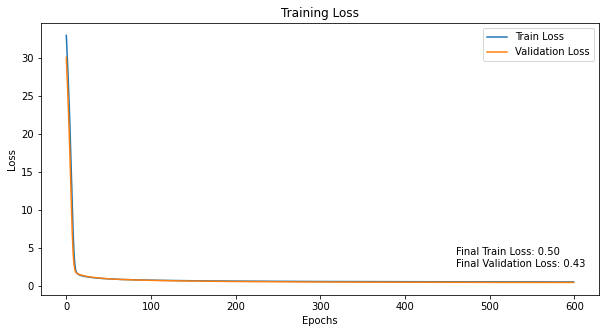

In [12]:
# Load the dataset
features = wines.drop(['quality', 'color'], axis=1).to_numpy()
target = wines['quality'].to_numpy()
target = target.reshape(-1, 1)

# Split the dataset into training and test sets
features, test_features, target, test_target = train_test_split(features, target, test_size=0.2, random_state=33)
train_features, val_features, train_target, val_target = train_test_split(features, target, test_size=0.1, random_state=33)

# Model
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(len(features[0]), 64)
        self.fc2 = nn.Linear(64, 32)  # Hidden layer to another hidden layer
        self.fc3 = nn.Linear(32, 1)  # Last hidden layer to output

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to hidden layers
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = RegressionModel()

# Define loss function and optimizer (same as before)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop (similar to previous example)
t_loss = []
v_loss = []
for epoch in tqdm(range(600)):

    # Train
    optimizer.zero_grad()
    outputs = model(torch.tensor(features, dtype=torch.float32))
    loss = criterion(outputs, torch.tensor(target, dtype=torch.float32))
    loss.backward()
    optimizer.step()
    t_loss.append(loss.item())

    # Validation
    with torch.no_grad():
        val_outputs = model(torch.tensor(val_features, dtype=torch.float32))
        val_loss = criterion(val_outputs, torch.tensor(val_target, dtype=torch.float32))
        v_loss.append(val_loss.item())

# Training Evolution
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Train Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.text(460, 2.5, f'Final Train Loss: {t_loss[-1]:.2f}\nFinal Validation Loss: {v_loss[-1]:.2f}')
plt.legend()
plt.show()

# Test
with torch.no_grad():
    test_outputs = model(torch.tensor(test_features, dtype=torch.float32))
    test_loss = criterion(test_outputs, torch.tensor(test_target, dtype=torch.float32))
    res = {'name': 'NN',
           'type': 'regression',
		   'technique': 'DL',
		   'model': model,
		   'featrures': 'All',
		   'score': test_loss.item()}
    results_reg = pd.concat([results_reg, pd.DataFrame([res])])

## Use of Case 4 - Classifying Wine Color - DL

100%|██████████| 600/600 [00:03<00:00, 150.64it/s]


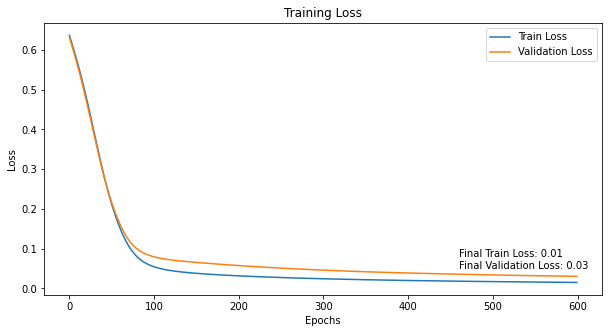

In [13]:
# Load the dataset
features = wines.drop(['quality', 'color', 'color_red', 'color_white'], axis=1).to_numpy()
target = wines['color'].map({'red': 0, 'white': 1}).to_numpy()
target = target.reshape(-1, 1)

# Split the dataset into training and test sets
features, test_features, target, test_target = train_test_split(features, target, test_size=0.2, random_state=33)
train_features, val_features, train_target, val_target = train_test_split(features, target, test_size=0.1, random_state=33)

# Model
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(len(features[0]), 64)
        self.fc2 = nn.Linear(64, 32)  # Hidden layer to another hidden layer
        self.fc3 = nn.Linear(32, 1)  # Last hidden layer to output

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to hidden layers
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

# Instantiate the updated model
model = ClassificationModel()

# Define loss function and optimizer (same as before)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (similar to previous example)
t_loss = []
v_loss = []
for epoch in tqdm(range(600)):

    # Train
    optimizer.zero_grad()
    outputs = model(torch.tensor(features, dtype=torch.float32))
    loss = criterion(outputs, torch.tensor(target, dtype=torch.float32))
    loss.backward()
    optimizer.step()
    t_loss.append(loss.item())

    # Validation
    with torch.no_grad():
        val_outputs = model(torch.tensor(val_features, dtype=torch.float32))
        val_loss = criterion(val_outputs, torch.tensor(val_target, dtype=torch.float32))
        v_loss.append(val_loss.item())

# Training Evolution
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Train Loss')
plt.plot(v_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.text(460, 0.05, f'Final Train Loss: {t_loss[-1]:.2f}\nFinal Validation Loss: {v_loss[-1]:.2f}')
plt.legend()
plt.show()

# Test
with torch.no_grad():
    test_outputs = model(torch.tensor(test_features, dtype=torch.float32))
    test_loss = criterion(test_outputs, torch.tensor(test_target, dtype=torch.float32))

# Confusion Matrix
y_pred = test_outputs.numpy()
y_pred = (y_pred > 0.5).astype(int)
y_true = test_target
confusion_matrix = pd.crosstab(y_true[:, 0], y_pred[:, 0], rownames=['Actual'], colnames=['Predicted'])

# Measures
tp = confusion_matrix[0][0]
tn = confusion_matrix[1][1]
fp = confusion_matrix[0][1]
fn = confusion_matrix[1][0]

res = {'name': 'NN',
       'type': 'classification',
	   'technique': 'DL',
	   'model': model,
	   'featrures': 'All',
	   'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
	   'accuracy': (tp + tn) / (tp + tn + fp + fn),
	   'precision': tp / (tp + fp),
	   'recall': tp / (tp + fn),
	   'f1': 2 * (tp / (tp + fp)) * (tp / (tp + fn)) / ((tp / (tp + fp)) + (tp / (tp + fn)))}
results_class = pd.concat([results_class, pd.DataFrame([res])])

## Comparison of Models

In [14]:
# Regression models results
results_reg

,name,type,technique,model,featrures,score
0,LogR,regression,ML,"LogisticRegression(C=1, max_iter=10000, random...","[volatile_acidity, citric_acid, residual_sugar...",0.532308
0,RFR,regression,ML,"(DecisionTreeRegressor(max_features='sqrt', ra...","[volatile_acidity, citric_acid, residual_sugar...",0.509545
0,GBR,regression,ML,([DecisionTreeRegressor(criterion='friedman_ms...,"[volatile_acidity, citric_acid, residual_sugar...",0.499309
0,MLP,regression,ML,"MLPRegressor(alpha=0.001, learning_rate='adapt...","[volatile_acidity, citric_acid, residual_sugar...",0.359066
0,NN,regression,DL,RegressionModel(\n (fc1): Linear(in_features=...,All,0.564212


In [15]:
# Classification models results
results_class

,name,type,technique,model,featrures,TP,TN,FP,FN,accuracy,precision,recall,f1
0,SVC,classification,ML,"SVC(C=1, cache_size=400, coef0=0.5, kernel='po...","[fixed_acidity, volatile_acidity, citric_acid,...",317,976,6,1,0.994615,0.981424,0.996855,0.989080
0,RFC,classification,ML,"(DecisionTreeClassifier(criterion='entropy', m...","[fixed_acidity, volatile_acidity, citric_acid,...",319,976,4,1,0.996154,0.987616,0.996875,0.992224
0,GBC,classification,ML,([DecisionTreeRegressor(criterion='friedman_ms...,"[fixed_acidity, volatile_acidity, citric_acid,...",318,977,5,0,0.996154,0.984520,1.000000,0.992200
0,MLP,classification,ML,"MLPClassifier(alpha=0.1, learning_rate='adapti...","[fixed_acidity, volatile_acidity, citric_acid,...",319,977,4,0,0.996923,0.987616,1.000000,0.993769
0,NN,classification,DL,ClassificationModel(\n (fc1): Linear(in_featu...,All,320,977,0,3,0.997692,1.000000,0.990712,0.995334


In [16]:
# Best regression model
results_reg[results_reg['score'] == results_reg['score'].max()]


,name,type,technique,model,featrures,score
0,NN,regression,DL,RegressionModel(\n (fc1): Linear(in_features=...,All,0.564212


In [17]:
# Best classification model
results_class[results_class['accuracy'] == results_class['accuracy'].max()]

,name,type,technique,model,featrures,TP,TN,FP,FN,accuracy,precision,recall,f1
0,NN,classification,DL,ClassificationModel(\n (fc1): Linear(in_featu...,All,320,977,0,3,0.997692,1.0,0.990712,0.995334


After training all models, and without any surprise, the bests model for both use cases are the Deep Learning models.